In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import SMOTE

from sklearn.metrics import accuracy_score

import seaborn as sns
%matplotlib inline

Using TensorFlow backend.
/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/harshdeep/accenture/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/harshdeep/accenture/lib/python3.6/site-pa

In [2]:
data = pd.read_csv('HURdat_ExtremeWeatherEvents.csv')

In [3]:
data.head()
data.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
data.columns

Index(['ID', 'Name', 'Status', 'Latitude', 'Longitude', 'Maximum.Wind',
       'date_time', 'diff', 'rapid_int', 'i', 'n', 'persistence', 'product',
       'Initial.Max', 'speed', 'speed_z', 'speed_m', 'Jday', 'Maximum.Wind_p',
       'Latitude_p', 'Longitude_p'],
      dtype='object')

In [5]:
X = data[['rapid_int', 'product', 'persistence', 'Maximum.Wind_p', 'Maximum.Wind', 'i', 'speed_m', 'speed_z', 'diff', 'Initial.Max', 'speed']].dropna(how='all')
X['product'] = X['product'].fillna(X['product'].median())
X['persistence'] = X['persistence'].fillna(X['persistence'].median())
X['Maximum.Wind_p'] = X['Maximum.Wind_p'].fillna(X['Maximum.Wind_p'].median())
X['speed_m'] = X['speed_m'].fillna(X['speed_m'].median())
X['speed_z'] = X['speed_z'].fillna(X['speed_z'].median())
X['diff'] = X['diff'].fillna(X['diff'].median())
X['speed'] = X['speed'].fillna(X['speed'].median())
X['Initial.Max'] = X['Initial.Max'].fillna(X['Initial.Max'].median())


In [6]:
X.shape

(8793, 11)

In [7]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X[['product', 'persistence', 'Maximum.Wind_p']])
len(kmeans.labels_)

8793

In [8]:
kmeans.labels_.shape

(8793,)

In [9]:
X['label'] = kmeans.labels_

In [10]:
## Sanity check for how many of the imputed values are correct
## which were valid in the original dataset
temp = X[~X['rapid_int'].isna()]
accuracy_score(list(temp['rapid_int']), list(temp['label']))

0.9279547062986554

In [11]:
X.shape

(8793, 12)

In [12]:
X.drop('rapid_int', axis=1, inplace=True)

In [13]:
X.head(2)

,product,persistence,Maximum.Wind_p,Maximum.Wind,i,speed_m,speed_z,diff,Initial.Max,speed,label
0,175.0,5.0,45.0,20,1,9.266244,0.028492,5.0,50.0,20.210114,0
1,175.0,5.0,20.0,25,2,9.266244,0.028492,5.0,20.0,20.210114,0


In [14]:
# X['speed_root'] = X['speed'].apply(lambda x: np.sqrt(x))

In [15]:
# X['Maximum.Wind'] = X['Maximum.Wind'].apply(lambda x: np.sqrt(x))
# X['Maximum.Wind_p'] = X['Maximum.Wind_p'].apply(lambda x: np.sqrt(x))
X['diff_wind'] = X['Maximum.Wind'] - X['Maximum.Wind_p']
X['speed_m_z']  = X['speed_m'] / X['speed_z']
X['diff_init_max'] = X['Initial.Max'] - X['Maximum.Wind']
# X['peristence_diff_ratio'] = X['persistence'] / (X['diff'] + 0.000001)

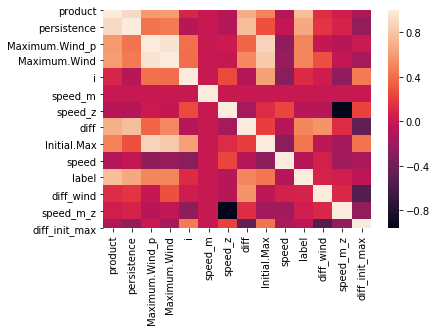

In [16]:
# calculate the correlation matrix
corr = X.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [17]:
label_indices = X.index[X['i'] - X['i'].shift(1) == 1] 
data_indices = label_indices - 1

X_ = X.loc[data_indices]
y = X.loc[label_indices, 'label']

In [18]:
X_ = scale(X_)

In [19]:
X_.shape, y.shape

((7708, 14), (7708,))

In [20]:
# smt = SMOTE()
# X_train, y_train = smt.fit_sample(X_, y)

In [21]:
# np.bincount(y_train)

## Logistic Regression

In [22]:
clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=10000)

In [23]:
scores = cross_val_score(clf, X_, y, cv=10, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.84 (+/- 0.08)


## Random Forest

In [24]:
clf = RandomForestClassifier(n_estimators=600, max_depth=14, random_state=0)

In [25]:
scores = cross_val_score(clf, X_, y, cv=10, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.85 (+/- 0.08)


## Xgboost algorithm

In [26]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [30]:
# fit model no training data
model = XGBClassifier(estimators=1000, max_depth=80)

scores = cross_val_score(model, X_, y, cv=10, scoring='f1')
print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

F1 Score: 0.84 (+/- 0.09)


In [44]:
# model = CatBoostClassifier(depth=10, iterations=60)

In [46]:
# scores = cross_val_score(model, X_, y, cv=10, scoring='f1')
# print("F1 Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))